In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "causality"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


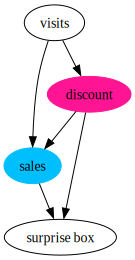

In [3]:
g = gr.Digraph()

g.node(name="sales", label="sales", color="deepskyblue", style="filled")
g.node(name="discount", label="discount", color="deeppink", style="filled")

g.edge(tail_name="discount", head_name="sales")
g.edge(tail_name="visits", head_name="discount")
g.edge(tail_name="visits", head_name="sales")
g.edge(tail_name="discount", head_name="surprise box")
g.edge(tail_name="sales", head_name="surprise box")

g


In [4]:
def generate_users_observational_data(n_users: int) -> pd.DataFrame:
    # data generation parameters
    sales_threshold = 12
    discount_probability = 0.8
    visit_discount_sales_factor = 0.15
    discount_surprise_box_probability = 0.3
    sales_surprise_box_probability = 0.7

    visits_dist = pm.NegativeBinomial.dist(mu=10, alpha=50)
    visits_samples = pm.draw(vars=visits_dist, draws=n_users, random_seed=rng) + 1

    is_discount_candidate = visits_samples > sales_threshold
    discount_distribution = pm.Bernoulli.dist(
        p=is_discount_candidate * discount_probability
    )
    discount_samples = pm.draw(vars=discount_distribution, random_seed=rng)

    sales_distribution = pm.Gamma.dist(
        mu=visits_samples * (1 + visit_discount_sales_factor * discount_samples) + 1,
        sigma=1,
    )
    sales_samples = pm.draw(vars=sales_distribution, random_seed=rng)
    is_surprise_box_sales_candidate = sales_samples > sales_threshold + 5

    probability_of_surprise_box = (
        discount_surprise_box_probability * discount_samples
        + sales_surprise_box_probability * is_surprise_box_sales_candidate
    )

    condition_1 = (probability_of_surprise_box >= 0).all()
    condition_2 = (probability_of_surprise_box <= 1).all()
    assert condition_1 and condition_2, "Probability of surprise box must be in [0, 1]"

    surprise_box_distribution = pm.Bernoulli.dist(p=probability_of_surprise_box)
    surprise_box_samples = pm.draw(vars=surprise_box_distribution, random_seed=rng)

    return pd.DataFrame(
        data={
            "visits": visits_samples,
            "discount": discount_samples,
            "surprise_box": surprise_box_samples,
            "sales": sales_samples,
        }
    )


data = generate_users_observational_data(n_users=1_000)

data.head()

,visits,discount,surprise_box,sales
0,6,0,0,8.364433
1,6,0,0,5.954542
2,13,1,1,17.548511
3,9,0,0,10.088339
4,13,0,0,14.246433


In [5]:
data

,visits,discount,surprise_box,sales
0,6,0,0,8.364433
1,6,0,0,5.954542
2,13,1,1,17.548511
3,9,0,0,10.088339
4,13,0,0,14.246433
...,...,...,...,...
995,13,1,0,16.940157
996,11,0,0,12.138124
997,10,0,0,11.140534
998,11,0,0,11.927710


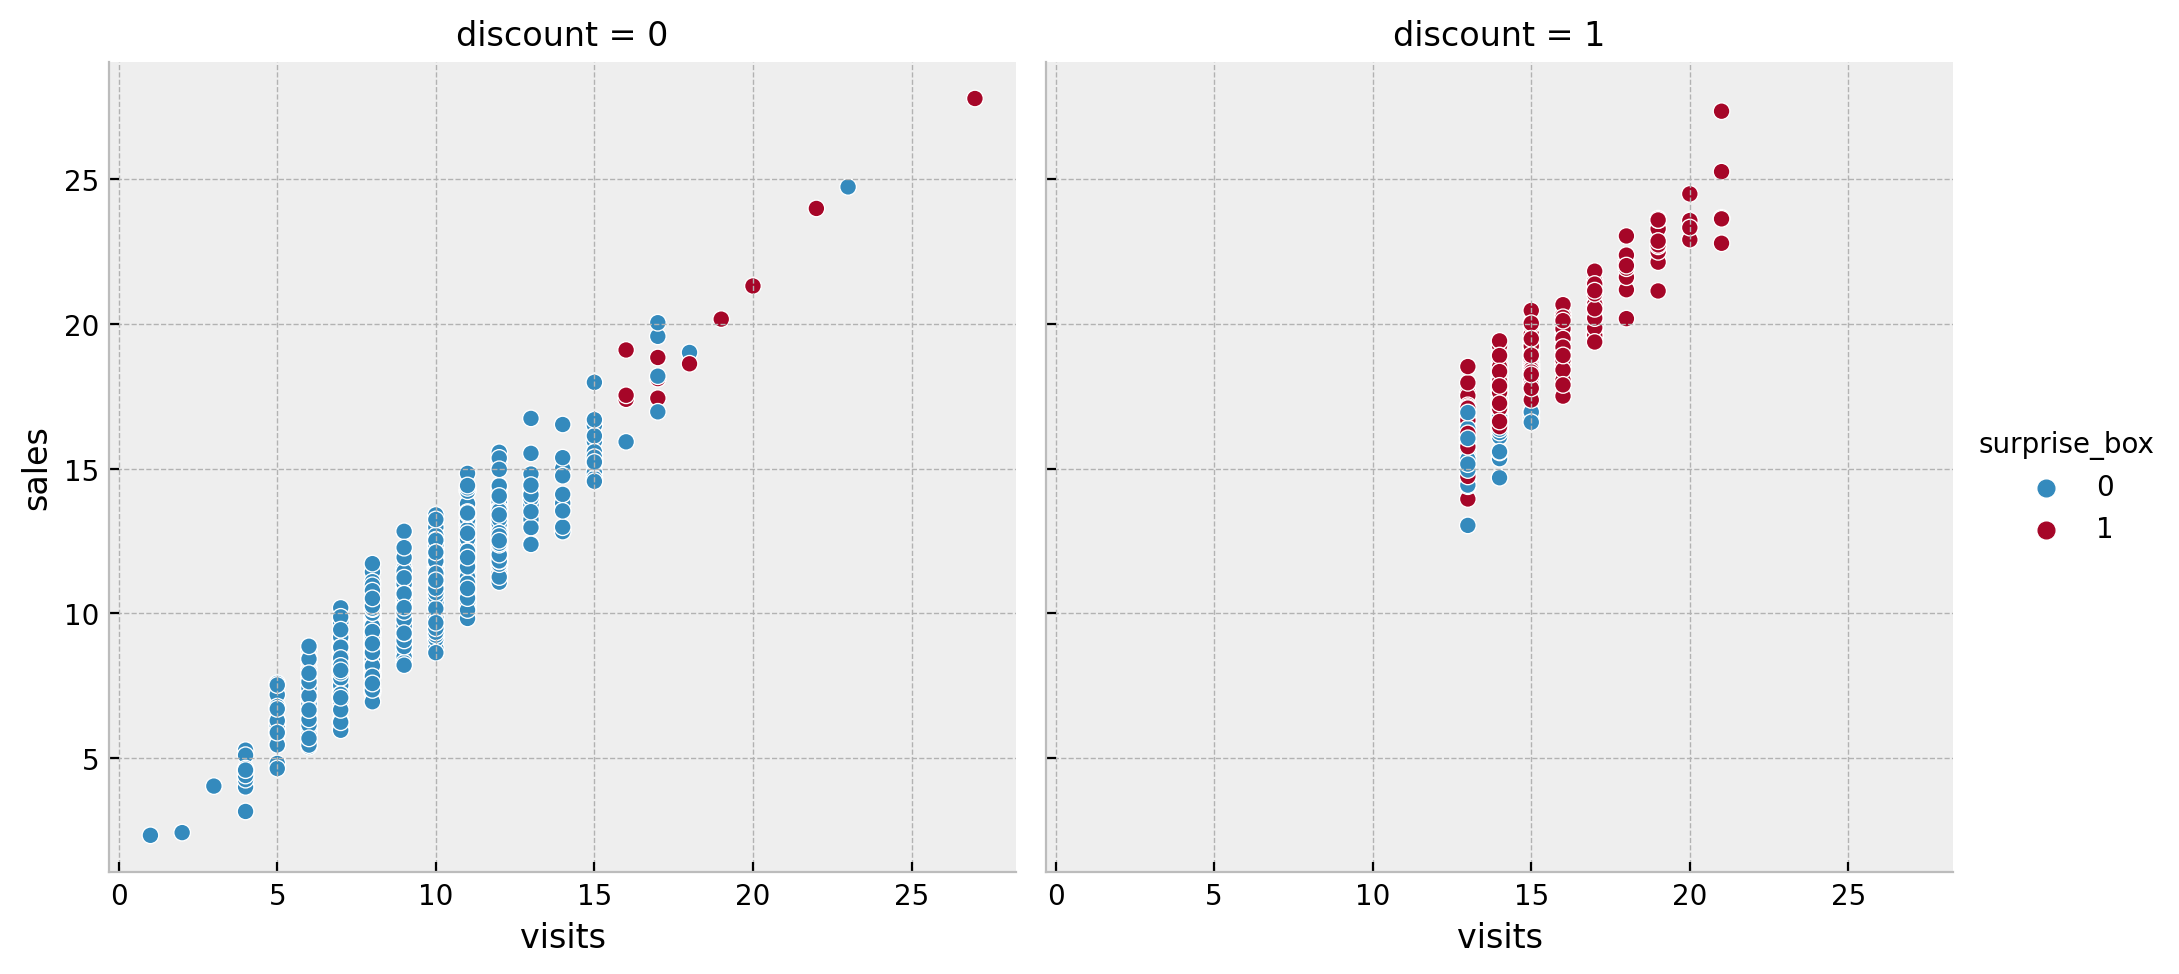

In [6]:
sns.relplot(data=data, x="visits", y="sales", hue="surprise_box", col="discount")

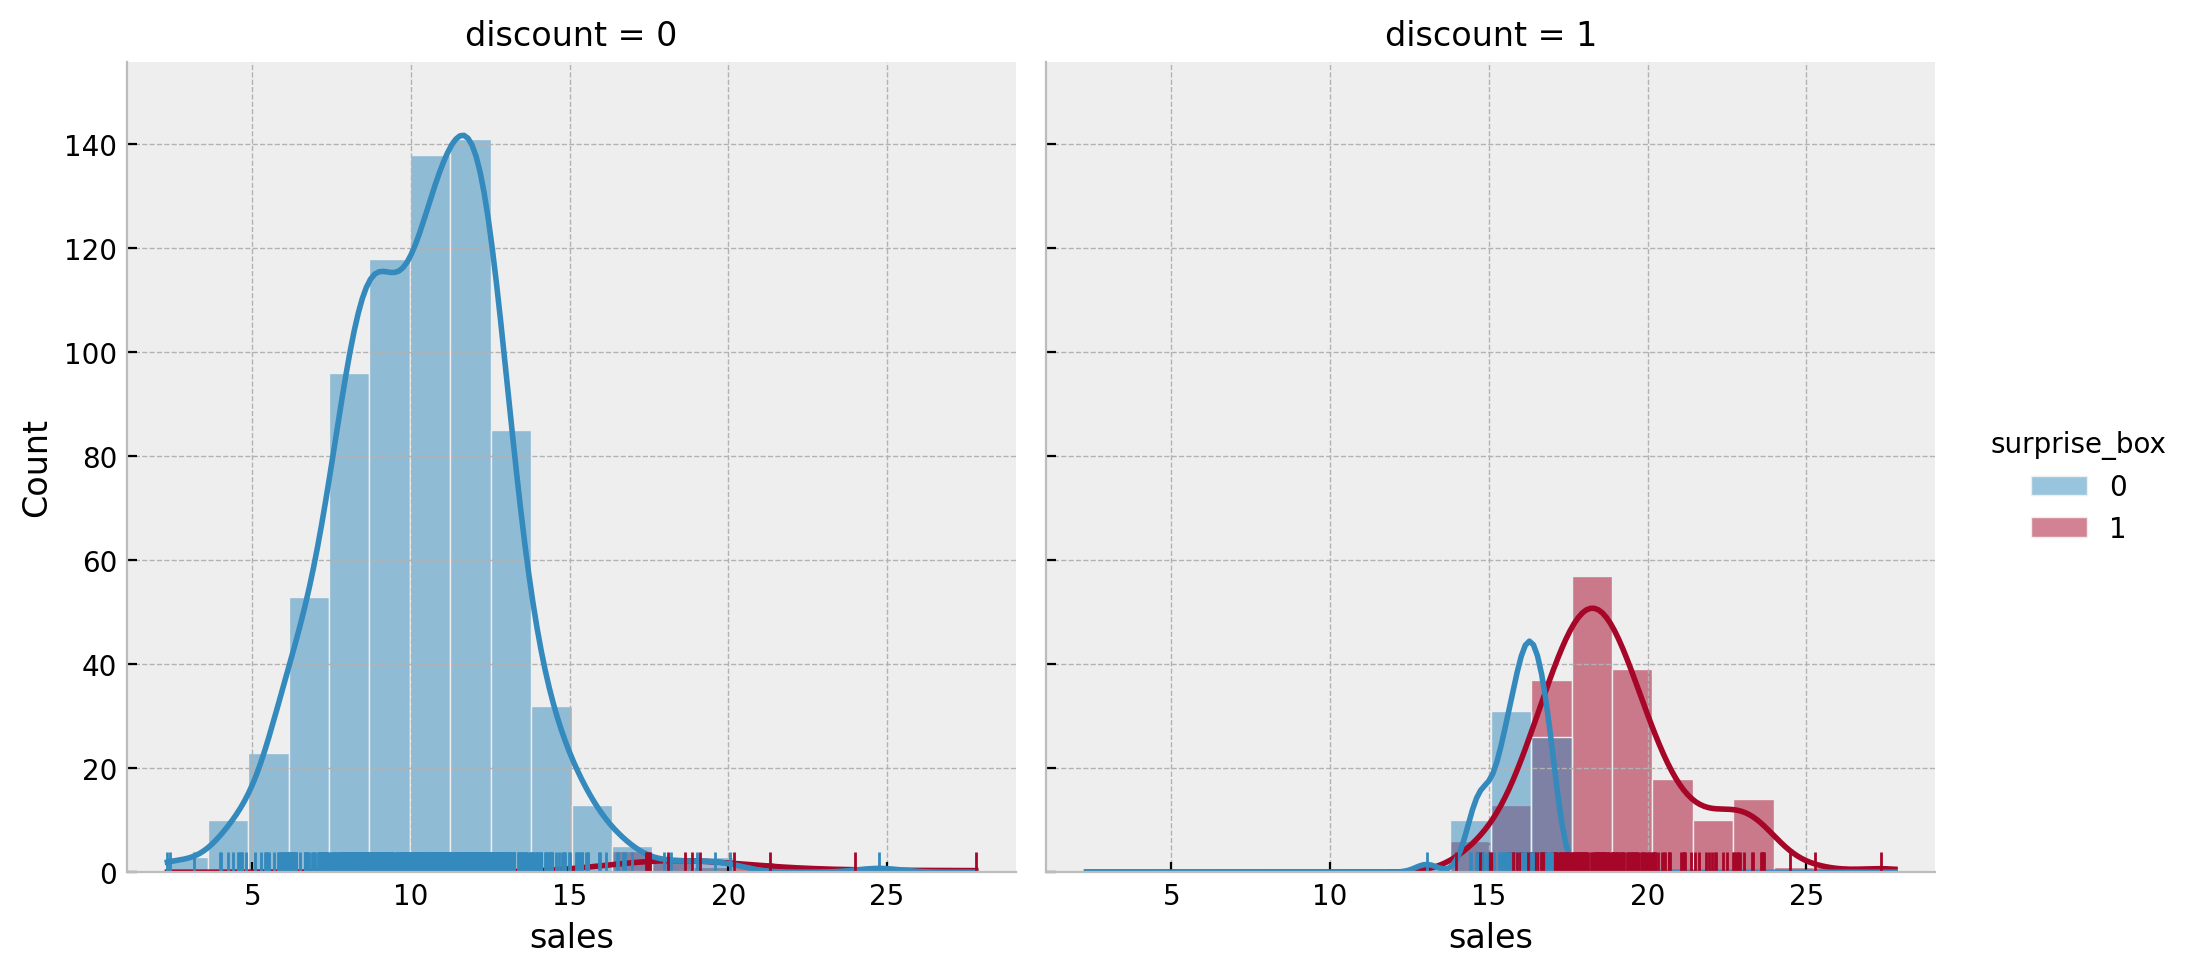

In [7]:
sns.displot(data=data, x="sales", hue="surprise_box", col="discount", kde=True, rug=True)

In [9]:
data.groupby(["discount"]).agg({"sales": "mean"})

,sales
discount,
0,10.572634
1,18.104224


In [11]:
data.groupby(["surprise_box", "discount"]).agg({"sales": "mean"})

sales
surprise_box discount           
0            0         10.419218
             1         15.927319
1            0         19.815919
             1         18.855643